In [15]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

In [17]:
from pathlib import Path

folder_path_cars = Path('C:/Users/laljarus/Documents/GitHub/TrainingData/vehicles/')
vehicles_path = [x for x in folder_path_cars.iterdir() if x.is_dir()]
cars = []

for path in vehicles_path:
    images = path.glob('*.png')
    for image  in images:
        cars.append(str(image))


folder_path_noncars = Path('C:/Users/laljarus/Documents/GitHub/TrainingData/non-vehicles/')
non_vehicles_path = [x for x in folder_path_noncars.iterdir() if x.is_dir()]
notcars = []

for path in non_vehicles_path:
    images = path.glob('*.png')
    for image in images:
        notcars.append(str(image))

In [18]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8792
random_idx = np.random.randint(0,len(cars),sample_size)
cars = np.array(cars)[random_idx]
notcars = np.array(notcars)[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "gray" # Can be 0, 1, 2, or "ALL" or "gray"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [350, 720] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t3=time.time()
svc.fit(X_train, y_train)
t4 = time.time()
print(round(t4-t3, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 2628
5.26 Seconds to train SVC...
Test Accuracy of SVC =  0.99


In [5]:
with open('svc_pickle.p','wb') as f:
    dictPickle = {'svc':svc,'scaler':X_scaler,'orient':orient,'pix_per_cell':pix_per_cell,
                  'cell_per_block':cell_per_block,'spatial_size':spatial_size,'hist_bins':hist_bins}
    pickle.dump(dictPickle,f)

C:\ProgramData\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


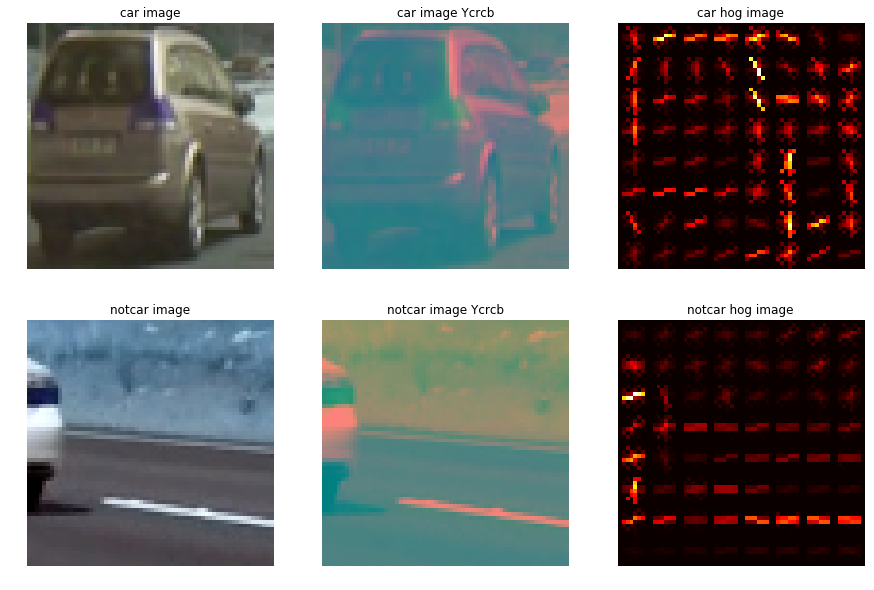

In [6]:
car_ind = np.random.randint(0,len(cars))
notcar_ind = np.random.randint(0,len(notcars))

car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])

car_spatial_feat = bin_spatial(car_image,size=spatial_size)
notcar_spatial_feat = bin_spatial(notcar_image,size=spatial_size)

car_img_yrcb = cv2.cvtColor(car_image,cv2.COLOR_BGR2YCrCb)
notcar_img_yrcb = cv2.cvtColor(notcar_image,cv2.COLOR_BGR2YCrCb)

car_hist_feat = color_hist(car_img_yrcb,hist_bins)
notcar_hist_feat = color_hist(notcar_img_yrcb,hist_bins)

car_hog_feat,car_hog_img = get_hog_features(cv2.cvtColor(car_image,cv2.COLOR_BGR2GRAY),
                                            orient,pix_per_cell,cell_per_block,vis = True)

notcar_hog_feat,notcar_hog_img = get_hog_features(cv2.cvtColor(notcar_image,cv2.COLOR_BGR2GRAY),
                                            orient,pix_per_cell,cell_per_block,vis = True)

vis_images  = [car_image,car_img_yrcb,car_hog_img,notcar_image,notcar_img_yrcb,notcar_hog_img]
vis_titles = ['car image','car image Ycrcb','car hog image','notcar image','notcar image Ycrcb','notcar hog image']
f = plt.figure(figsize=(15,10))
visualize(f,2,3,vis_images,vis_titles)

(0, 752)

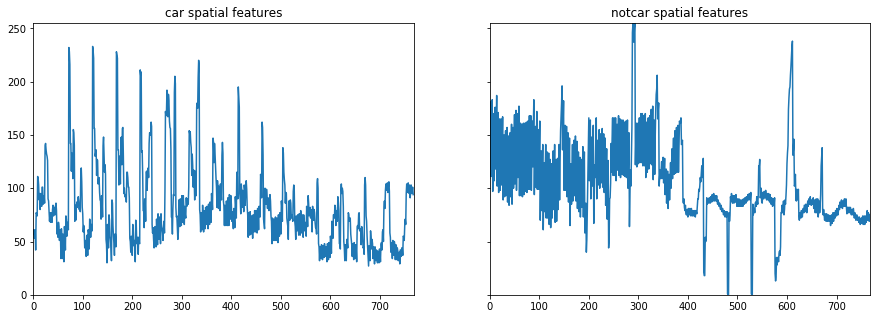

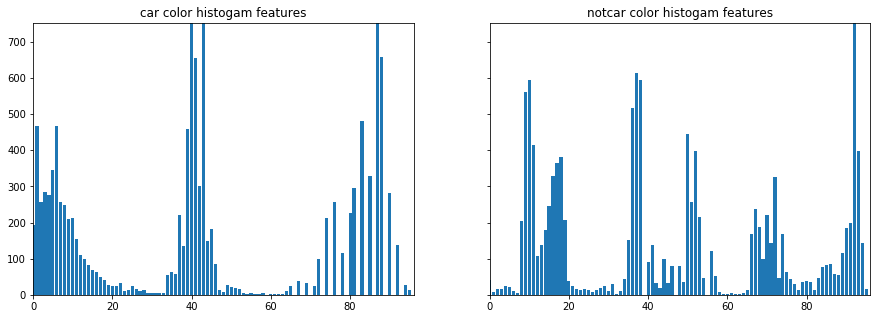

In [7]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

ax1.plot(car_spatial_feat)
ax1.set_title('car spatial features')
ax1.set_xlim(0,len(car_spatial_feat))
ax1.set_ylim(0,max(car_spatial_feat))

ax2.plot(notcar_spatial_feat)
ax2.set_title('notcar spatial features')
ax2.set_xlim(0,len(notcar_spatial_feat))
ax2.set_ylim(0,max(notcar_spatial_feat))

fig, (ax3,ax4) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

ax3.bar(range(len(car_hist_feat)),car_hist_feat)
ax3.set_title('car color histogam features')
ax3.set_xlim(0,len(car_hist_feat))
ax3.set_ylim(0,max(car_hist_feat))


ax4.bar(range(len(notcar_hist_feat)),notcar_hist_feat)
ax4.set_title('notcar color histogam features')
ax4.set_xlim(0,len(notcar_hist_feat))
ax4.set_ylim(0,max(notcar_hist_feat))

In [8]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins,cells_per_step = 2,hog_gray = False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    #nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    #nyblocks = (ch1.shape[0] // pix_per_cell) + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    #nblocks_per_window = (window // pix_per_cell)+ 1
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    if hog_gray == True:
        ctrans_tosearch_rgb = cv2.cvtColor(ctrans_tosearch,cv2.COLOR_YCrCb2RGB)
        ctrans_tosearch_gray = cv2.cvtColor(ctrans_tosearch,cv2.COLOR_RGB2GRAY)
        hog = get_hog_features(ctrans_tosearch_gray, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
    else:
        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    hot_windows = []
    windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            if hog_gray == True:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            else:
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
            
            if test_prediction == 1:                
                hot_windows.append([(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)])
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    heatmap = add_heat(heatmap,hot_windows)
    return hot_windows,heatmap,windows

In [9]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
img_names = glob.glob('./test_images/*.jpg')
#img = mpimg.imread('./test_images/test5.jpg')
#print('pix_per_cell:',pix_per_cell)
#print('cell_per_block:',cell_per_block)
#print(img.shape)

out_images = []
titles = []
scales = [1.2,1.4,2.2]
ystart = [400,400,464]
ystop = [528,656,720]

for img_name in img_names:
    
    t1 = time.time()
    
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    heatmap_sum = np.zeros_like(img[:,:,0]).astype(np.float)
    n_windows = 0
    
    for i in range(len(scales)):
        
        hot_windows,heatmap,windows = find_cars(img, ystart[i], ystop[i], scales[i], svc, X_scaler,
                                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_gray=True)
        
        heatmap_sum = np.add(heatmap_sum,heatmap)
        n_windows += len(windows)
    
    #for window in hot_windows:
    #    cv2.rectangle(img,window[0],window[1],(0,0,255),6)
    
    #out_images.append(img)
    #titles.append(img_name.split('\\')[1])    
        
    out_images.append(heatmap_sum) 
    titles.append(img_name.split('\\')[1]+' heatmap')
    
    heatmap = apply_threshold(heatmap_sum,2)
    labels = label(heatmap_sum)
    
    img_labeled = draw_labeled_bboxes(np.copy(img),labels)
    out_images.append(img_labeled)
    titles.append(img_name.split('\\')[1]) 
    
    t2  = time.time() 
    time_diff = t2-t1
    print(time_diff," seconds is required to detect cars in the image ",img_name)
    print(n_windows, ' windows are used')
    

C:\ProgramData\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.5294342041015625  seconds is required to detect cars in the image  ./test_images\straight_lines1.jpg
753  windows are used
0.5313878059387207  seconds is required to detect cars in the image  ./test_images\straight_lines2.jpg
753  windows are used
0.5324418544769287  seconds is required to detect cars in the image  ./test_images\test1.jpg
753  windows are used
0.5444228649139404  seconds is required to detect cars in the image  ./test_images\test2.jpg
753  windows are used
0.529433012008667  seconds is required to detect cars in the image  ./test_images\test3.jpg
753  windows are used
0.5343949794769287  seconds is required to detect cars in the image  ./test_images\test4.jpg
753  windows are used
0.5324432849884033  seconds is required to detect cars in the image  ./test_images\test5.jpg
753  windows are used
0.5374007225036621  seconds is required to detect cars in the image  ./test_images\test6.jpg
753  windows are used
0.5213871002197266  seconds is required to detect cars in the

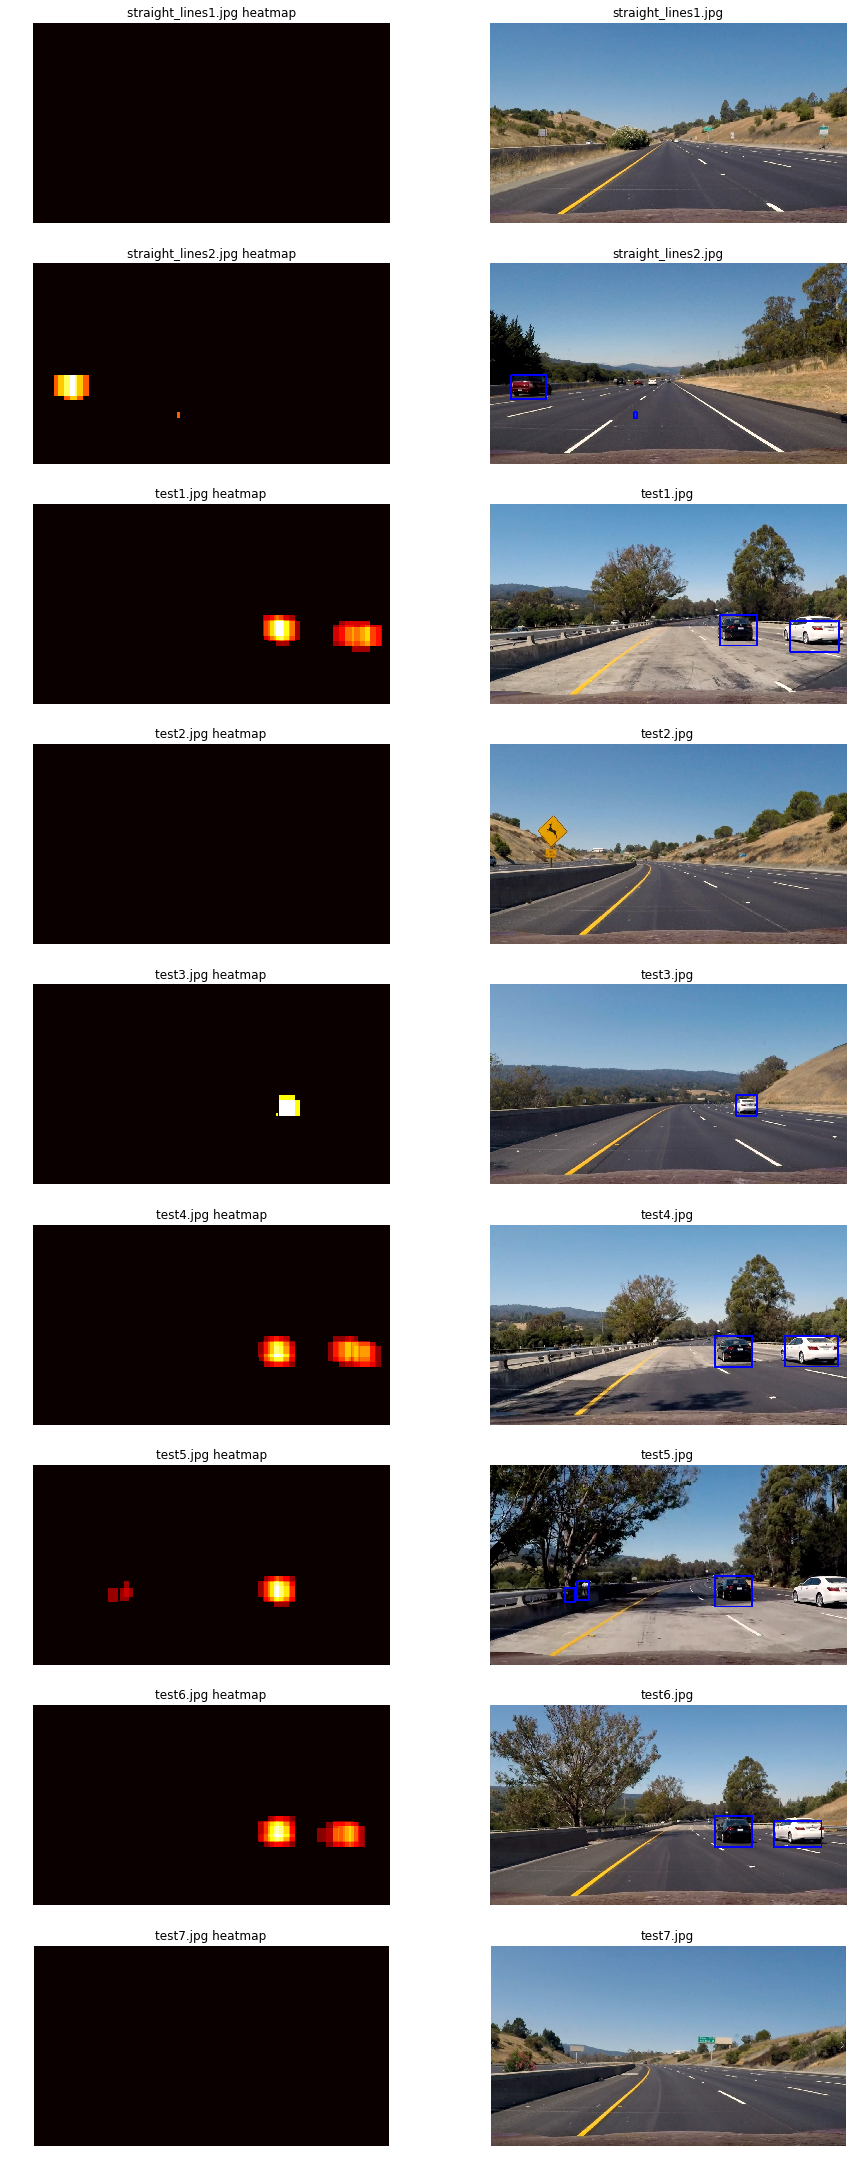

In [10]:
fig = plt.figure(figsize=(15,70))
visualize(fig,16,2,out_images,titles)

C:\ProgramData\Anaconda3\envs\carnd-term1-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


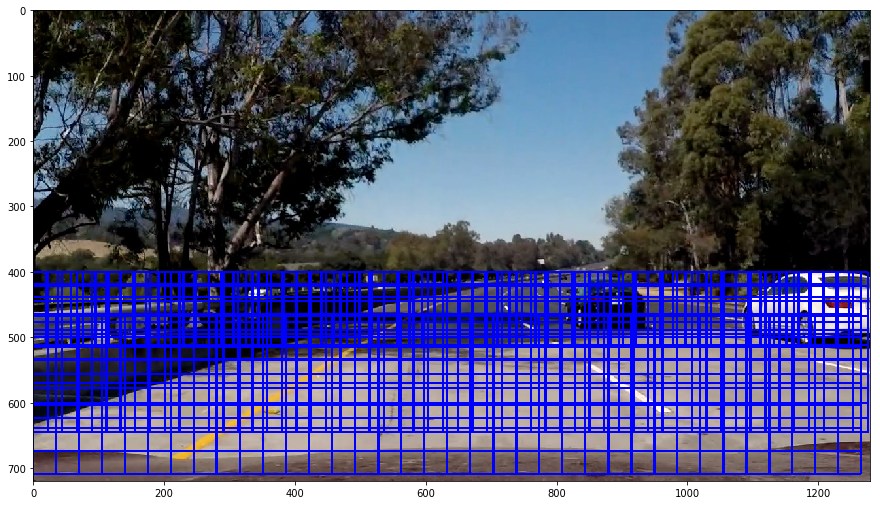

In [11]:
img = cv2.imread('./test_images/test5.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
hot_windows,heatmap_1,windows_1 = find_cars(img, ystart[0], ystop[0], scales[0], svc, X_scaler,orient, pix_per_cell,
                                        cell_per_block, spatial_size, hist_bins,cells_per_step = 2,hog_gray = True)
hot_windows,heatmap_2,windows_2 = find_cars(img, ystart[1], ystop[1],scales[1], svc, X_scaler,orient, pix_per_cell,
                                        cell_per_block, spatial_size, hist_bins,cells_per_step = 2,hog_gray = True)
hot_windows,heatmap_3,windows_3 = find_cars(img, ystart[2], ystop[2], scales[2], svc, X_scaler,orient, pix_per_cell,
                                        cell_per_block, spatial_size, hist_bins,cells_per_step = 2,hog_gray = True)
windows = windows_1+windows_2+windows_3
#out_windows = draw_boxes(img,windows_1,color = (255,0,0),thick = 2)
#out_windows = draw_boxes(img,windows_2,color = (0,255,0),thick = 2)
out_windows = draw_boxes(img,windows,color = (0,0,255),thick = 2)
fig1 = plt.figure(figsize=(15,30))
#visualize(fig1,3,1,[out_windows_1,out_windows_2,out_windows_3],['small windows','medium_windows','large_windows'])
plt.imshow(out_windows)

In [12]:
class Test:
    def __init__(self):
        # counter to count the frame number in the video
        self.counter = 1
        # counter to count and reset n frames 
        self.arr_heatmap_frames = []    
        

In [13]:
with open('CameraCalibration.p','rb') as f:
    data = pickle.load(f)
mtx = data[1]
dist = data[2]
TestObj = Test()


def process_image(image):
    
    global mtx
    global dist
    global TestObj
    
    # Undistorting image:
    undist = cv2.undistort(image, mtx, dist, None)
    
    dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
    svc = dist_pickle["svc"]
    X_scaler = dist_pickle["scaler"]
    orient = dist_pickle["orient"]
    pix_per_cell = dist_pickle["pix_per_cell"]
    cell_per_block = dist_pickle["cell_per_block"]
    spatial_size = dist_pickle["spatial_size"]
    hist_bins = dist_pickle["hist_bins"]
    
    scales = [1.2,1.6,2.2]
    ystart = [400,400,464]
    ystop = [528,656,720]
    
        
    heatmap_frame = np.zeros_like(undist[:,:,0]).astype(np.float)
    #arr_heatmap_frames = []
    n_windows = 0
    
    for i in range(len(scales)):
        
        hot_windows,heatmap,windows = find_cars(undist, ystart[i], ystop[i], scales[i], svc, X_scaler,
                                        orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_gray = True)
        
        heatmap_frame = np.add(heatmap_frame,heatmap)
        n_windows += len(windows)   
                               
    
        
    if TestObj.counter<=10:
        threshold = 2*(TestObj.counter)
        TestObj.arr_heatmap_frames.append(heatmap_frame)
        TestObj.counter +=1
    else:           
        threshold = 20
        del TestObj.arr_heatmap_frames[0]
        TestObj.arr_heatmap_frames.append(heatmap_frame)
                            
                            
    heatmap_frames = sum(TestObj.arr_heatmap_frames)                            
    heatmap_thresholded = apply_threshold(heatmap_frames,threshold)
    labels = label(heatmap_thresholded)    
    output_image = draw_labeled_bboxes(np.copy(undist),labels,thickness=2,area_thres =100)
    
    return output_image

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

write_output = 'project_video_output_1.mp4'
clip1 = VideoFileClip('project_video.mp4')
#clip1 = VideoFileClip('test_video.mp4')

write_clip = clip1.fl_image(process_image)

%time write_clip.write_videofile(write_output, audio=False)

[MoviePy] >>>> Building video project_video_output_1.mp4
[MoviePy] Writing video project_video_output_1.mp4


100%|█████████▉| 1260/1261 [10:53<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_1.mp4 

Wall time: 10min 53s


0.579564094543457  time taken to process the image


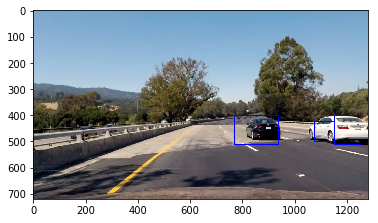

In [52]:
t1 = time.time()
image = mpimg.imread(img_names[5])

out_test_img = process_image(image)
plt.imshow(out_test_img)
t2 = time.time()
print(t2-t1,' time taken to process the image')